In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/processed.csv")
df['Date'] = pd.to_datetime(df['Date'])
print df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346733 entries, 0 to 346732
Data columns (total 14 columns):
Unnamed: 0    346733 non-null int64
Port Name     346733 non-null object
State         346733 non-null object
Port Code     346733 non-null int64
Border        346733 non-null object
Date          346733 non-null datetime64[ns]
Measure       346733 non-null object
Value         346733 non-null int64
Location      346733 non-null object
location_x    346733 non-null float64
location_y    346733 non-null float64
year          346733 non-null int64
month         346733 non-null int64
agg_month     346733 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 37.0+ MB
None


Some feature engineering:
1. generate new features: day-of-the-week and whether it's weekday
2. one-hot encode categorical features

In [3]:
df['day_of_the_week'] = df['Date'].dt.dayofweek
df['is_week_day'] = (df['day_of_the_week'] < 5).astype(int)

def transfer_column(df_input):
    num_features = ['agg_month', 'day_of_the_week', 'Value', 'year', 'month']
    ctg_features = ['Port Name', 'State', 'Border', 'Measure', 'is_week_day']
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", OneHotEncoder(), ctg_features)
    ])
    np_pipelined = full_pipeline.fit_transform(df_input)
    import scipy
    if isinstance(np_pipelined, scipy.sparse.csr.csr_matrix):
        np_pipelined = np_pipelined.toarray()
    df_pipelined = pd.DataFrame(np_pipelined, index=df_input.index)
    return df_pipelined

Training isolation forest on California cross border entry data

In [4]:
df_CA = df[(df['State'] == 'California')]

In [17]:
def train_isolation_forest(df_input, outliers_fraction=0.05):
    df_input_pipelined = transfer_column(df_input)
    df_input_pipelined = pd.DataFrame(df_input_pipelined)
    outliers_fraction = 0.05
    IF_model = IsolationForest(contamination=outliers_fraction, n_estimators=200, )
    IF_model.fit(df_input_pipelined)
    print "Isolation forest trained, making predictions..."
    df_input_pipelined['is_anomaly'] = pd.Series(IF_model.predict(df_input_pipelined))
    df_input_pipelined['is_anomaly'] = df_input_pipelined['is_anomaly'].map( {1: 0, -1: 1} )
    print "Predictions made."
    return df_input_pipelined

def plot_anomaly_using_tsne(df_input, df_with_prediction, size=None):
    print "Plotting predictions using tsne..."
    from sklearn.manifold import TSNE
    df_input_pipelined = transfer_column(df_input)
    if df_input_pipelined.shape[1] == 1:
        df_input_pipelined = df_input_pipelined
    tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=0, random_state=0, angle=0.75)
    tsne_vectors = tsne_model.fit_transform(df_input_pipelined)

    anomalies_indices = df_with_prediction[df_with_prediction['is_anomaly'] == 1].index
    tsne_vectors_anomaly = [v for idx, v in enumerate(tsne_vectors) if idx in anomalies_indices]
    fig, ax = plt.subplots(figsize=(10, 10))
    COLOR_MAP = np.array(["#9edae6"])
    plt.scatter(x=tsne_vectors[:, 0], y=tsne_vectors[:, 1], color=COLOR_MAP, marker='o', alpha=0.5, s=size)
    plt.scatter(x=[v[0] for v in tsne_vectors_anomaly], y=[v[1] for v in tsne_vectors_anomaly],
                color='red', marker='o', alpha=0.5, s=size)
    plt.show()

Isolation forest trained, making predictions...


/Library/Python/2.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Predictions made.
Plotting predictions using tsne...


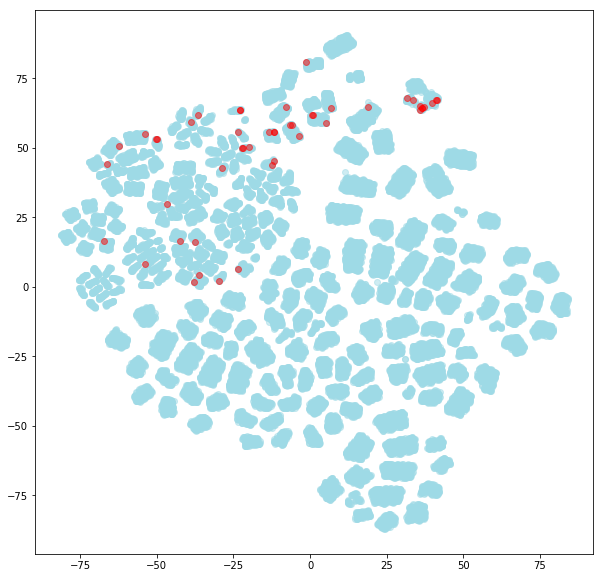

In [18]:
df_with_prediction = train_isolation_forest(df_CA)
plot_anomaly_using_tsne(df_CA, df_with_prediction)

In [8]:
df_input_pipelined = train_isolation_forest(df_CA)
anomalies_indices = df_input_pipelined[df_input_pipelined['is_anomaly'] == 1].index
df_anomaly = df_CA[df_CA.index.isin(anomalies_indices)]
df_anomaly.to_csv("../data/processed/anomalies_CA.csv")
df_anomaly.head()

Isolation forest trained, making predictions...


/Library/Python/2.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Predictions made.


,Unnamed: 0,Port Name,State,Port Code,Border,Date,Measure,Value,Location,location_x,location_y,year,month,agg_month,day_of_the_week,is_week_day
19,19,San Ysidro,California,2504,US-Mexico Border,2019-03-01,Bus Passengers,7779,POINT (-117.02666999999998 32.54306),-117.02667,32.54306,2019,3,279,4,1
152,152,Calexico East,California,2507,US-Mexico Border,2019-03-01,Train Passengers,21,POINT (-115.48433000000001 32.67524),-115.48433,32.67524,2019,3,279,4,1
354,354,Otay Mesa,California,2506,US-Mexico Border,2019-03-01,Rail Containers Empty,235,POINT (-117.05333 32.57333),-117.05333,32.57333,2019,3,279,4,1
844,844,Otay Mesa,California,2506,US-Mexico Border,2019-02-01,Bus Passengers,1690,POINT (-117.05333 32.57333),-117.05333,32.57333,2019,2,278,4,1
944,944,Calexico,California,2503,US-Mexico Border,2019-02-01,Personal Vehicle Passengers,682264,POINT (-115.49806000000001 32.67889),-115.49806,32.67889,2019,2,278,4,1


Anomaly samples deep dive
[(('San Ysidro', 'Buses'), 5), (('San Ysidro', 'Pedestrians'), 4), (('Otay Mesa', 'Trains'), 3), (('Tecate', 'Truck Containers Empty'), 3), (('San Ysidro', 'Personal Vehicle Passengers'), 3), (('Otay Mesa', 'Personal Vehicle Passengers'), 2), (('Otay Mesa', 'Bus Passengers'), 2)]


/Users/yelin/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Library/Python/2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


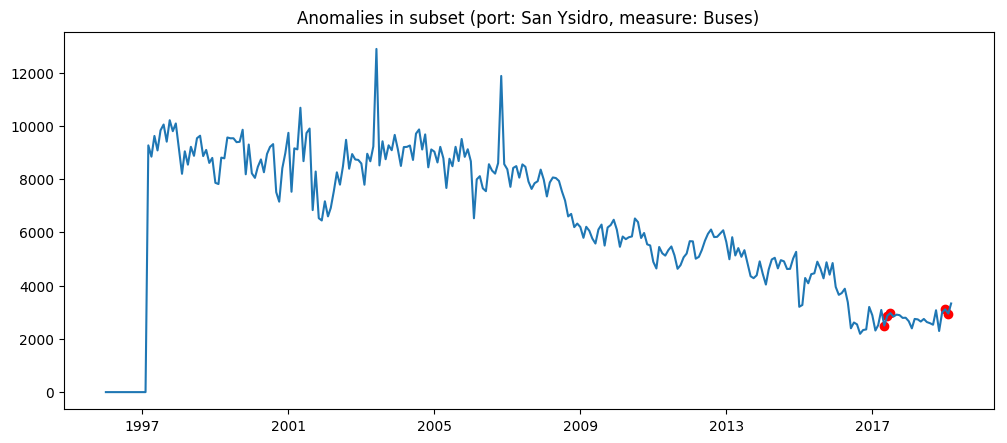

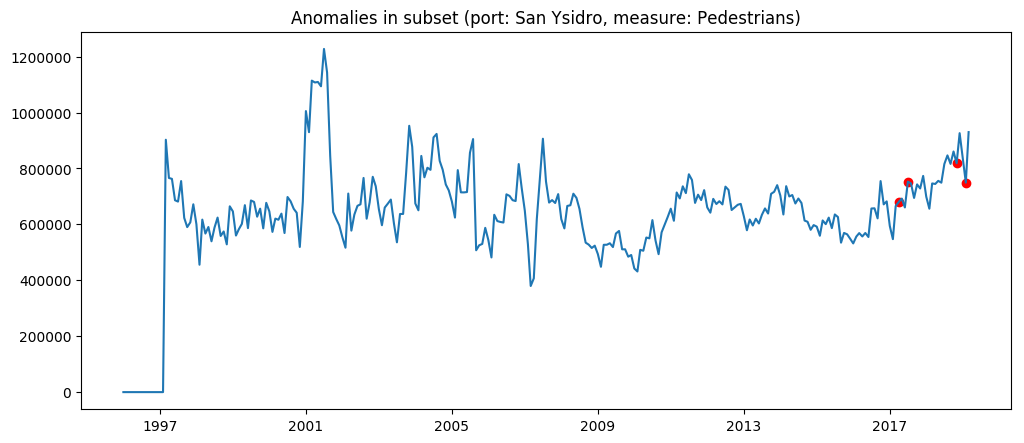

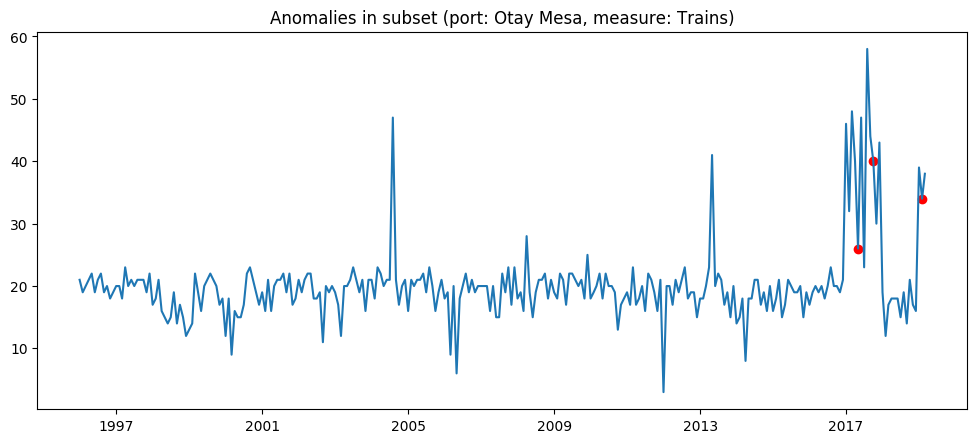

In [9]:
def plot_anomalies_breakdown(df_anomaly, n_deep_dive_sample=3):
    print "Anomaly samples deep dive"
    from itertools import islice
    sorted_uniques = df_anomaly.groupby(['Port Name', 'Measure']).size().sort_values(ascending=False)
    print list(islice(sorted_uniques.iteritems(), 7))
    for i in range(n_deep_dive_sample):
        port_name, measure = list(islice(sorted_uniques.iteritems(), n_deep_dive_sample))[i][0]
        df_anml_condition = df[(df['Port Name'] == port_name) & (df['Measure'] == measure)]
        anml_sample_indices = df_anomaly[(df_anomaly['Port Name'] == port_name) & (df['Measure'] == measure)].index.to_list()

        plt.figure(figsize=(12, 5), dpi=100)
        plt.title("Anomalies in subset (port: {}, measure: {})".format(port_name, measure))
        plt.plot(df_anml_condition['Date'], df_anml_condition['Value'])
        for index in anml_sample_indices:
            plt.scatter(df_anml_condition.loc[index, :]['Date'], df_anml_condition.loc[index, :]['Value'], color='red')
plot_anomalies_breakdown(df_anomaly)

Isolation forest trained, making predictions...


/Library/Python/2.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Predictions made.
Plotting predictions using tsne...


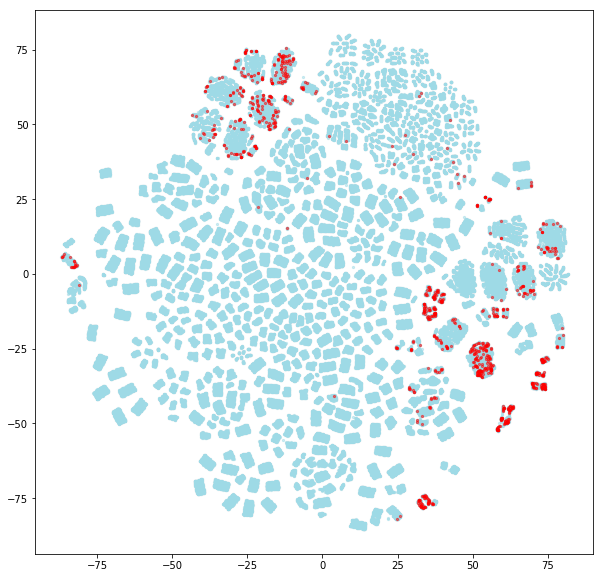

In [19]:
df_us_mx = df[(df['Border'] == 'US-Mexico Border')]
df_with_prediction = train_isolation_forest(df_us_mx)
plot_anomaly_using_tsne(df_us_mx, df_with_prediction, size=5)

Anomaly samples deep dive
[(('El Paso', 'Personal Vehicles'), 9), (('El Paso', 'Truck Containers Full'), 9), (('Nogales', 'Buses'), 8), (('Tornillo-Fabens', 'Rail Containers Empty'), 8), (('San Luis', 'Buses'), 8), (('Tecate', 'Truck Containers Full'), 7), (('Otay Mesa', 'Personal Vehicle Passengers'), 7)]


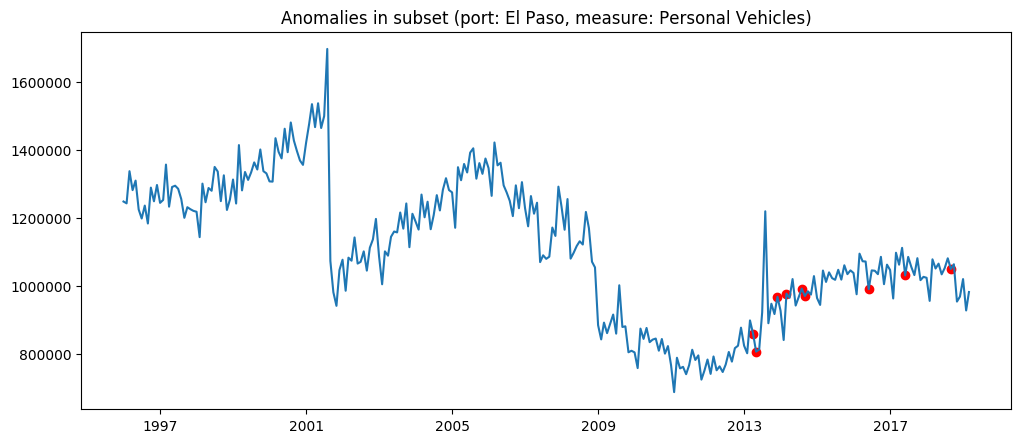

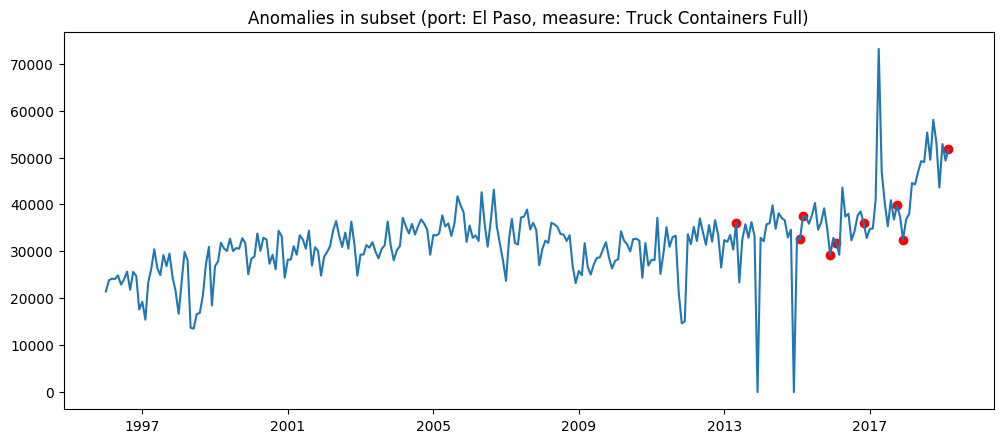

In [244]:
df_us_mx_pipelined = df_with_prediction
anomalies_us_mx_indices = df_us_mx_pipelined[df_us_mx_pipelined['is_anomaly'] == 1].index
df_anomaly_us_mx = df_us_mx[df_us_mx.index.isin(anomalies_us_mx_indices)]
df_anomaly_us_mx.to_csv("../data/processed/anomalies_US_Mexico_border.csv")
plot_anomalies_breakdown(df_anomaly_us_mx, n_deep_dive_sample=2)

Training One Class SVM

In [10]:
def train_one_class_SVM(df_input, outliers_fraction=0.05):
    from sklearn.svm import OneClassSVM
    df_input_pipelined = transfer_column(df_input)
    df_input_pipelined = pd.DataFrame(df_input_pipelined)
    
    OCS_model = OneClassSVM(nu=0.95 * outliers_fraction)
    OCS_model.fit(df_input_pipelined)
    
    print "One Class SVM trained, making predictions..."
    df_input_pipelined['is_anomaly'] = pd.Series(OCS_model.predict(df_input_pipelined))
    df_input_pipelined['is_anomaly'] = df_input_pipelined['is_anomaly'].map( {1: 0, -1: 1} )
    print "Predictions made."
    return df_input_pipelined

One Class SVM trained, making predictions...
Predictions made.
Plotting predictions using tsne...


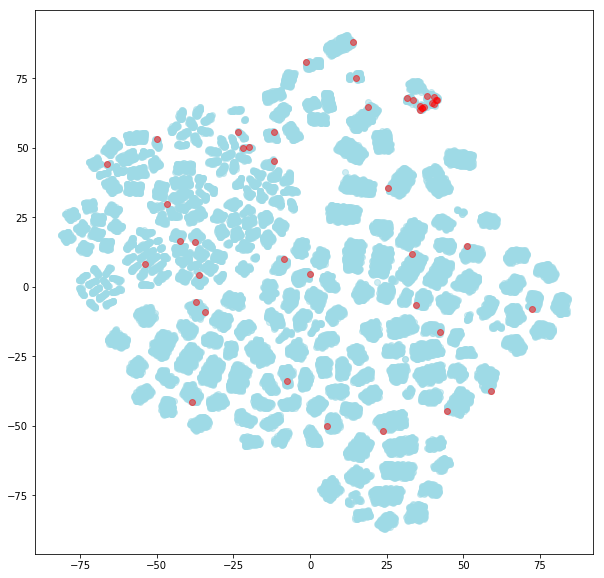

In [20]:
df_with_prediction = train_one_class_SVM(df_CA)
plot_anomaly_using_tsne(df_CA, df_with_prediction)

Anomaly samples deep dive
[(('Otay Mesa', 'Trains'), 4), (('Otay Mesa', 'Buses'), 3), (('San Ysidro', 'Buses'), 3), (('Otay Mesa', 'Trucks'), 2), (('Otay Mesa', 'Personal Vehicle Passengers'), 2), (('Otay Mesa', 'Train Passengers'), 2), (('Otay Mesa', 'Truck Containers Full'), 2)]


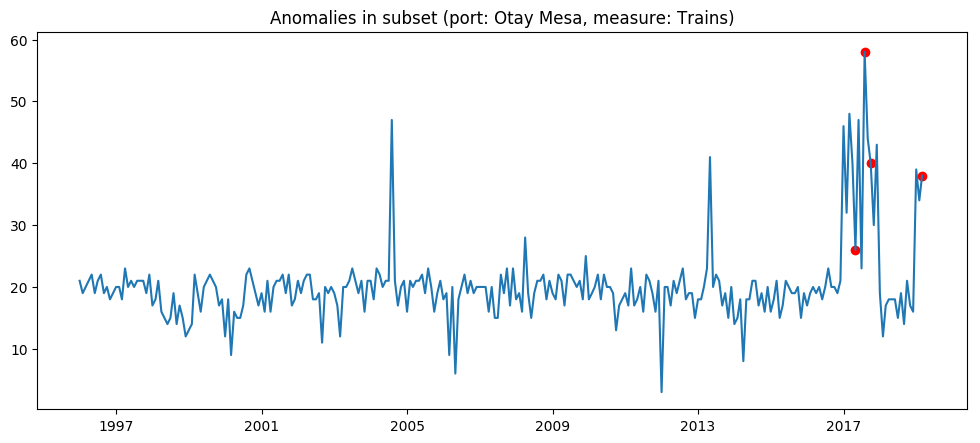

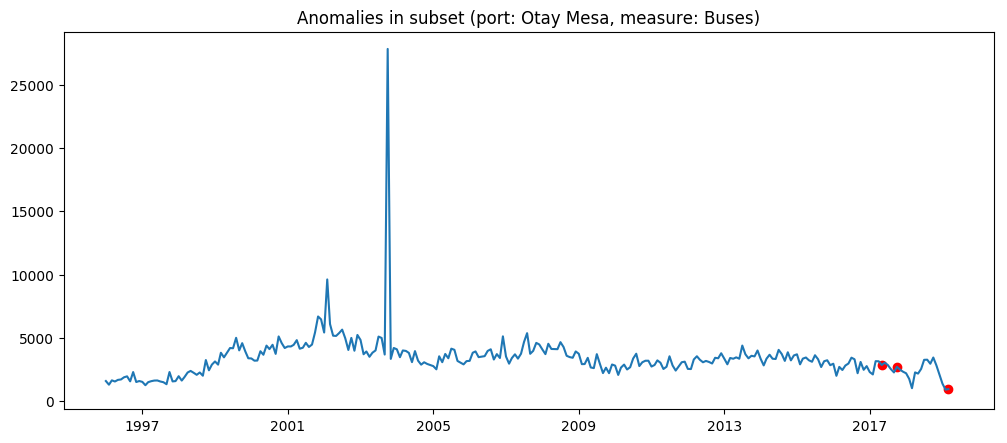

In [248]:
df_with_prediction_CA = df_with_prediction
anomalies_us_mx_indices = df_with_prediction_CA[df_with_prediction_CA['is_anomaly'] == 1].index
df_anomaly_us_mx = df_us_mx[df_us_mx.index.isin(anomalies_us_mx_indices)]
df_anomaly_us_mx.to_csv("../data/processed/anomalies_CA_by_OCS.csv")
plot_anomalies_breakdown(df_anomaly_us_mx, n_deep_dive_sample=2)

One Class SVM trained, making predictions...
Predictions made.
Plotting predictions using tsne...


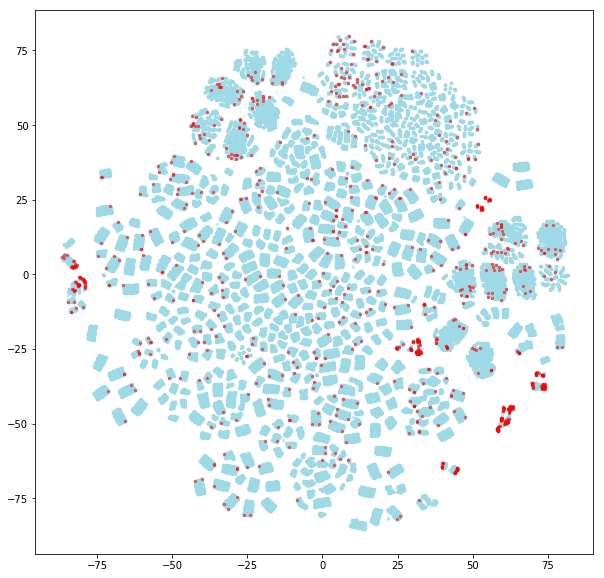

In [21]:
df_us_mx = df[(df['Border'] == 'US-Mexico Border')]
df_with_prediction = train_one_class_SVM(df_us_mx)
plot_anomaly_using_tsne(df_us_mx, df_with_prediction, size=5)